# Absenteeism at Work

Table of Content:

1. **Introduction** 

2. **Problem description**

3. **Data set loading and preparation**
  1. Libraries and dataset loading 
  2. Data Understanding  
  3. Data Cleaning
  
4. **Feature Engineering** 
  1. Logistic Regression Model
  2. Chi Squared
  3. Information Gain
  2. Ridge Model
  3. Lasso Model
  
5. **Result analysis of ML models** 
  1. Random Forest Algorithm
  
6. **Conclusion**
  1. Prediction of model
 

Let's go for it:

## 1. Introduction

Absenteeism is an employee's intentional or habitual absence from work. While employers expect workers to miss a certain number of workdays each year, excessive absences can equate to decreased productivity and can have a major effect on company finances, morale and other factors. 

People miss work for a variety of reasons, many of which are legitimate and others less so:

The HR department of a certain company has contacted us to help them reduce the number and duration of the absences of the company employees.They have collected all the recent absences together with its duration and a set of features that they consider important.

## 2.Problem Description

Our work is help them to understand what are the most important features (those more related to long absences) as well as to provide a Machine Learning model to identify beforehand absences that might potentially be prolonged in time.

## 3. Data set loading and preparation

Before starting cleaning the data, we want to make sure that we have all the librairies needed and functions loaded to ease the process of modelling.

In [2]:
# Install latest sklearn version
!python3 -m pip install scikit-learn --upgrade
import sklearn

Requirement already up-to-date: scikit-learn in /Applications/anaconda3/lib/python3.7/site-packages (0.22.1)


### Loading all the libraries

In [3]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Loading useful functions

In [4]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=28)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features), fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()

**Now let's start!**


In this part, we load the two csv files; training and test sets. In order to maintain consistency between the two files, we append both datasets to do the cleaning in the same way:

In [5]:
training = pd.read_csv('Absenteeism_at_work_classification_training.csv', sep=';', decimal=".")
test = pd.read_csv("Absenteeism_at_work_classification_test.csv", delimiter=";", decimal=".")

In [6]:
test['Absenteeism'] = 0
dataset = training.append(test)

In [7]:
pd.options.display.max_columns = training.shape[1] # It prints the info in all the columns

dataset.describe()

,ID,Reason.for.absence,Month.of.absence,Day.of.the.week,Seasons,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Disciplinary.failure,Education,Son,Social.drinker,Social.smoker,Pet,Weight,Height,Body.mass.index,ID.Worker,Absenteeism
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,370.500000,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,18.017568,0.294595
std,213.763888,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,11.021247,0.456169
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,1.000000,0.000000
25%,185.750000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,9.000000,0.000000
50%,370.500000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,18.000000,0.000000
75%,555.250000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,28.000000,1.000000
max,740.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,36.000000,1.000000


We then make sure that our data does not contain any NULL values, before handeling outliers

In [8]:
dataset.isnull().sum()

ID                                 0
Reason.for.absence                 0
Month.of.absence                   0
Day.of.the.week                    0
Seasons                            0
Transportation.expense             0
Distance.from.Residence.to.Work    0
Service.time                       0
Age                                0
Work.load.Average.day              0
Hit.target                         0
Disciplinary.failure               0
Education                          0
Son                                0
Social.drinker                     0
Social.smoker                      0
Pet                                0
Weight                             0
Height                             0
Body.mass.index                    0
ID.Worker                          0
Absenteeism                        0
dtype: int64

In [9]:
dataset.dtypes

ID                                   int64
Reason.for.absence                   int64
Month.of.absence                     int64
Day.of.the.week                      int64
Seasons                              int64
Transportation.expense               int64
Distance.from.Residence.to.Work      int64
Service.time                         int64
Age                                  int64
Work.load.Average.day              float64
Hit.target                           int64
Disciplinary.failure                 int64
Education                            int64
Son                                  int64
Social.drinker                       int64
Social.smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body.mass.index                      int64
ID.Worker                            int64
Absenteeism                          int64
dtype: object

Also, it seems that they all are integers. However, some variables must be converted to categorical variables. For instance, ID, ID.Worker, Reason.for.absence, Month.of.absence, Day.of.the.week, Seasons, Disciplinary.failure, Social.drinker, Social.smoker, and Absenteeism should be categorical variables helping our future model perform better

In [10]:
categorical_columns = ['ID', 'ID.Worker','Reason.for.absence', 'Month.of.absence', 'Day.of.the.week', 'Seasons', 'Disciplinary.failure', 'Social.drinker', 'Social.smoker', 'Absenteeism']

dataset[categorical_columns] = dataset[categorical_columns].astype("category")
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                             int64
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

In [11]:
reason_for_absence_dict={0:'Infectious parasitic diseases',
                         1:'Neoplasms',
                         2:'Diseases of the blood',
                         3:'Endocrine and metabolic diseases',
                         4:'Mental and behavioural disorders',
                         5:'Diseases of the nervous system',
                         6:'Diseases of the eye and adnexa',
                         7:'Diseases of the ear and mastoid process',
                         8:'Diseases of the circulatory system',
                         9:'Diseases of the respiratory system',
                         10:'Diseases of the digestive system',
                         11:'Diseases of the skin and subcutaneous tissue',
                         12:'Diseases of the musculoskeletal system and connective tissue', 
                         13:'Diseases of the genitourinary system',
                         14:'Pregnancy, childbirth and the puerperium',
                         15:'Certain conditions originating in the perinatal',
                         16:'Congenital malformations, deformations and chromosomal abnormalities',
                         17:'Symptoms, signs and abnormal clinical  findings',
                         18:'Injury, poisoning and certain other consequences of external causes',
                         19:'causes of morbidity and mortality',
                         21:'Factors influencing health status and contact with health services',
                         22:'patient follow-up',
                         23:'medical consultation',
                         24:'blood donation',
                         25:'laboratory examination',
                         26:'unjustified absence',
                         27:'physiotherapy',
                         28:'dental consultation'}

dataset['Reason.for.absence'] = dataset['Reason.for.absence'].replace(reason_for_absence_dict).astype('category')

dataset.Seasons = dataset.Seasons.replace({1:'summer',2:'autumn',3:'winter',4:'spring'}).astype('category')

dataset.Education = dataset.Education.replace({1:'highschool',2:'graduate',3:'postgraduate',4:'master&PhD'}).astype('category')

After a small analaysis of the features, we start to understand how each feature could affect the result of the predictions. For instance, we started thinking about the features that could possibly be extremly important and the ones that could be less important and possibly could be deleted:

We decided to delete the columns Height and Weight for two main reasons: First because Height and Weight could be simply replaced by Body mass index and secondly because we strongly think that height and weight could not be related or at least affect the least the result of our future model

In [12]:
dataset = dataset.drop(columns="Height")

In [13]:
dataset = dataset.drop(columns="Weight")

In [15]:
dataset["Pet"].describe()



count    740.000000
mean       0.745946
std        1.318258
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: Pet, dtype: float64

**Analyzing the Pet feature** :
It seems that number of pet per employee ranges from 0 to 8. HOWEVER, 50% people working at this company do not own a domestic animal, and 75% have at maximum 1 pet or 0. This distribution made us think twice because now, Pet seems less relevant in predicting the absenteeism. this made us decide to drop this feature and not include it in our model.


In [66]:
dataset = dataset.drop(columns="Pet")

We then have to dummify the categorical features in the dataset so we can train our ML models. We will also standardize the numerical values:

In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = dataset.columns[dataset.dtypes=='category'].tolist()
categorical_cols.remove('Absenteeism') # Remove the target variable

# I do not want to include the ID or the ID of the worker
categorical_cols.remove('ID') 
categorical_cols.remove('ID.Worker')
numerical_cols = dataset.columns[dataset.dtypes!='category'].tolist()

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns
dummified_dataset = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                               dataset['Absenteeism'].reset_index(drop=True)], axis=1)

**Now running first test**

Accuracy = 0.8111


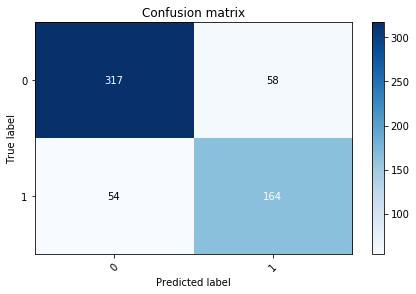

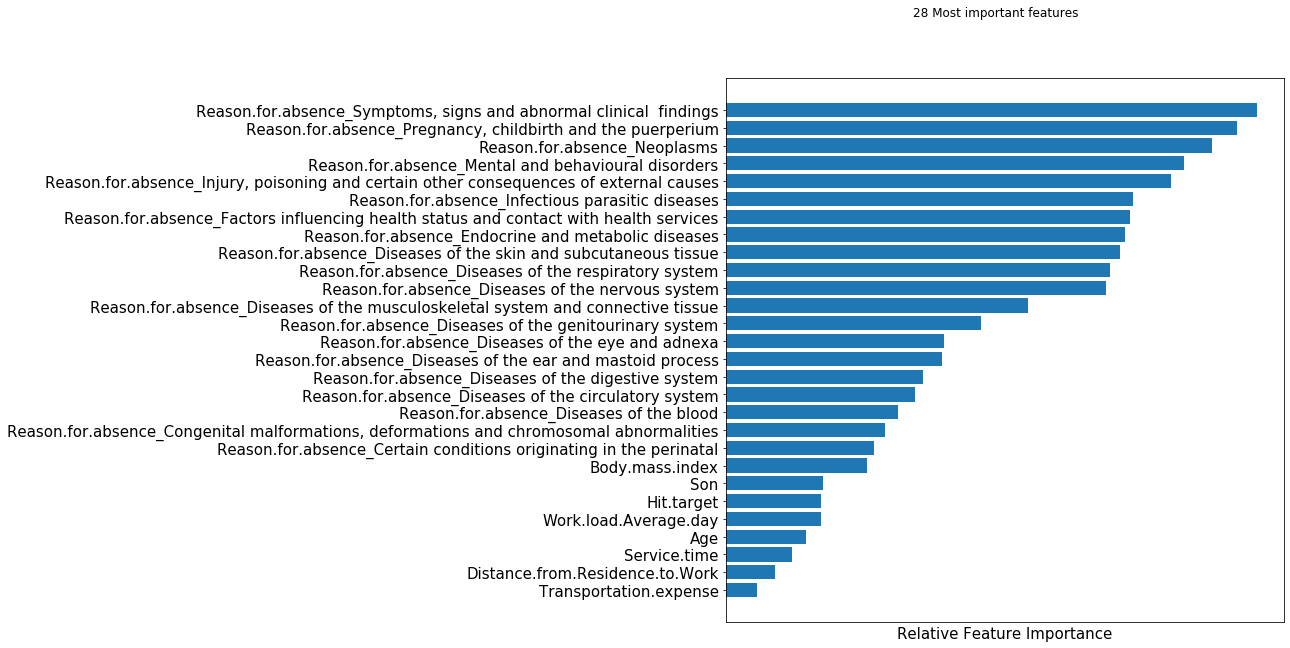

In [68]:
baseline_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))

Accuracy around 81%, but could possibly be improved. It also gave us an idea of the most important features that should be considered later on to be able to predict the Absenteeism.

Also, from the result given above, we see for the first time the ranking of the reasons for absence: Mainly reasons are related to medical issues, which makes sense somehow because the main reason still, to not being able to go to work is having a medical condition that is serious enough to prevent you from going.
We can also maybe assume that given this ranking, people working in this company are somewhat unhealthy.But these are only primary conclusions, let's see how we can improve this and increase accuracy.

**We must now deal with outliers since they have to ability to alter the final predictions and should be treated before going forward.**

### Handeling Outliers

We start by plotting them using the .boxplot as seen below: This will allow us to visualize our data, see what features contain the most outliers but also try to understand the **distribution** of our features:

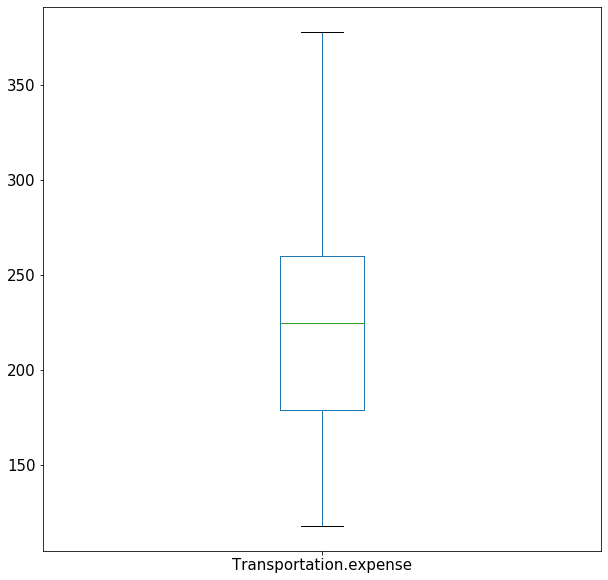

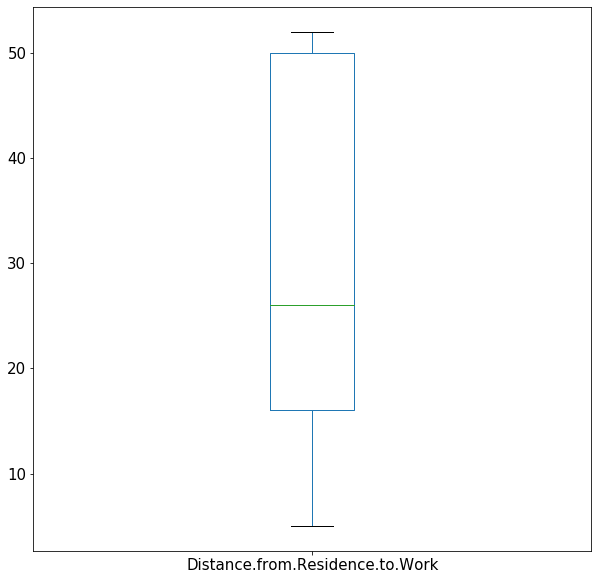

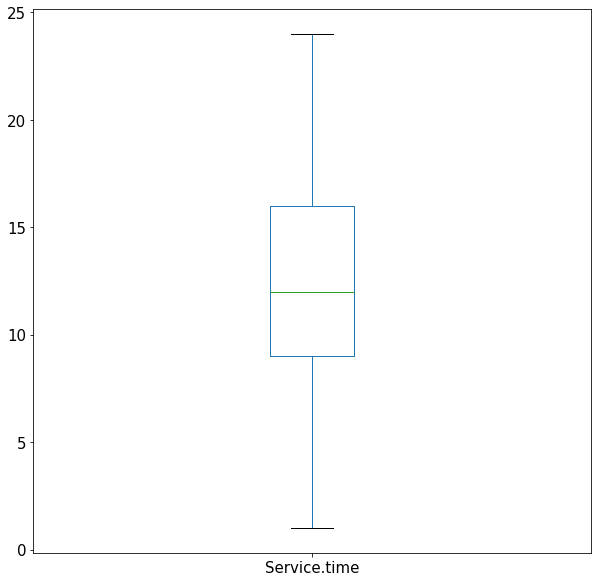

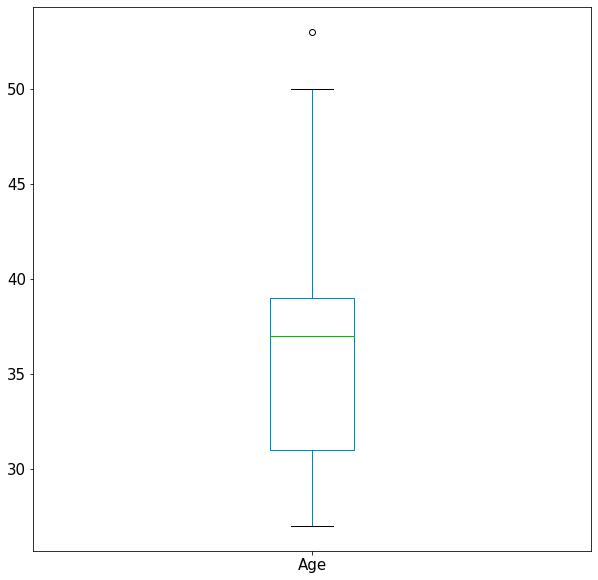

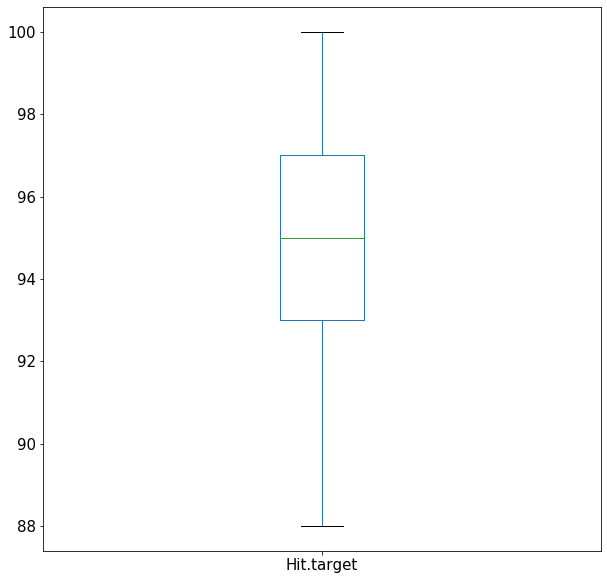

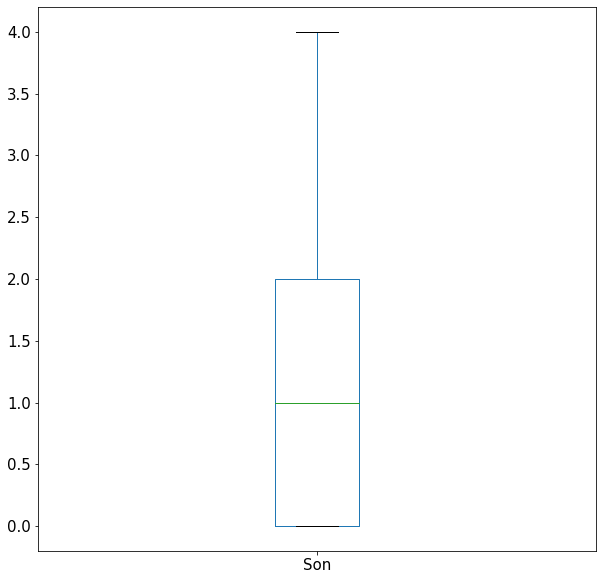

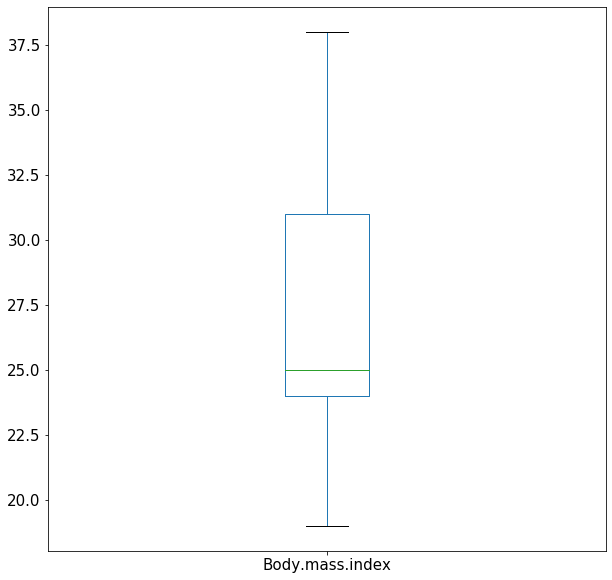

In [99]:
plt.figure(figsize=(10,10))
dataset.boxplot(['Transportation.expense'], grid=False, fontsize=15)

plt.figure(figsize=(10,10))
dataset.boxplot(['Distance.from.Residence.to.Work'], grid=False, fontsize=15)

plt.figure(figsize=(10,10))
dataset.boxplot(['Service.time'], grid=False, fontsize=15)

plt.figure(figsize=(10,10))
dataset.boxplot(['Age'], grid=False, fontsize=15)

plt.figure(figsize=(10,10))
dataset.boxplot(['Hit.target'], grid=False, fontsize=15)

plt.figure(figsize=(10,10))
dataset.boxplot(['Son'], grid=False, fontsize=15)

plt.figure(figsize=(10,10))
dataset.boxplot(['Body.mass.index'], grid=False, fontsize=15)


Body mass index being as seen above an important feature, we now understand and confirm that a lot of people working in this company over overweight, which could lead to a lot of health complications and thus not being able to go to work. We keep this feature.

In [ ]:
dataset = dataset.drop(columns="Pet")

In [70]:
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                          category
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

In [71]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [72]:
dataset = remove_outlier(dataset,'Transportation.expense')

dataset = remove_outlier(dataset,'Service.time')

dataset = remove_outlier(dataset,'Age')

dataset = remove_outlier(dataset,'Hit.target')




3 outliers removed
5 outliers removed
8 outliers removed
31 outliers removed


Now that our data has been cleaned we can procede with feature engineering

# Feature Engineering

**Now that we have removed all the outliers, we need to split our data between train and test to be able to do feature engineering (Chi squared and Information gain) and cross validation.**:

We use the function train_test_split and use the dummified dataset as seen below:

In [73]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], test_size=0.33, random_state=42)




## Chi-squared selection

The Chi Square aims to compare each feature with the target variable It will basically give you an accuracy score to compare. some of its Pros that we learnt in class are that the test is very fast abd simple to apply, however, it doesn’t take into consideration interaction between features.

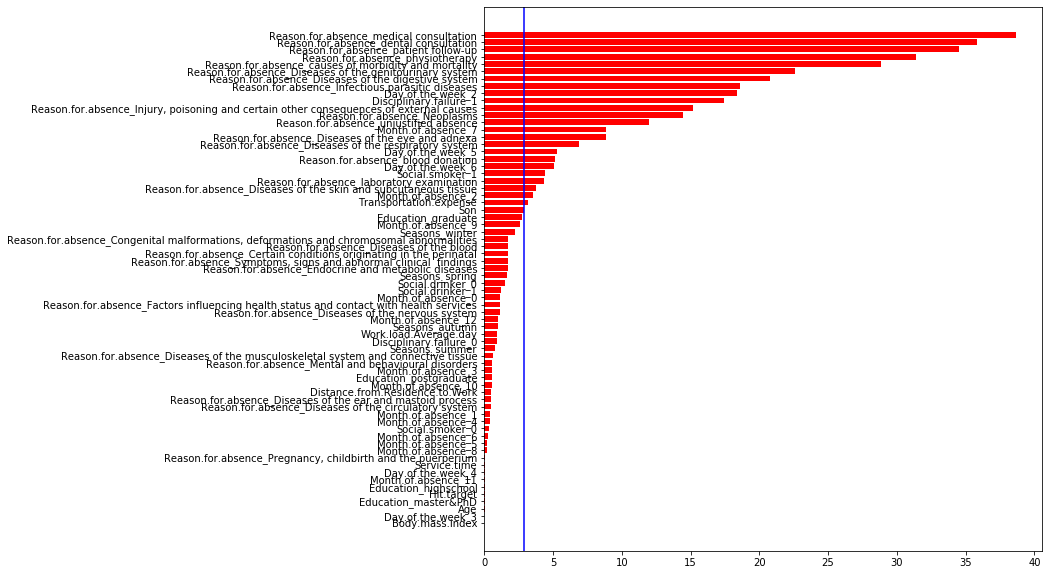

ChiSquared Threshold 2.8979301340860983


In [74]:
from sklearn.feature_selection import SelectKBest, chi2
from operator import itemgetter

chi2_selector = SelectKBest(score_func=chi2).fit(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'])

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = defaultdict(float)
for i in range(len(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1).columns)):
    chi2_features[dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1).columns[indices[i]]] += chi2_selector.scores_[indices[i]]
    
items = sorted(chi2_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(10,10))
plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
plt.barh(list(range(len(keys))), values, color='r', align='center')
chi2_th = pd.Series(list(chi2_features.values())).quantile(0.25)*6
plt.axvline(chi2_th, color='blue')
plt.gca().invert_yaxis()

plt.show()

print("ChiSquared Threshold", chi2_th)

The Chi Squared test gave us the unrelated features, so we remove them and check the Accuracy of our selection:

Features to remove = dict_keys(['Education_graduate', 'Month.of.absence_9', 'Seasons_winter', 'Reason.for.absence_Congenital malformations, deformations and chromosomal abnormalities', 'Reason.for.absence_Diseases of the blood', 'Reason.for.absence_Certain conditions originating in the perinatal', 'Reason.for.absence_Symptoms, signs and abnormal clinical  findings', 'Reason.for.absence_Endocrine and metabolic diseases', 'Seasons_spring', 'Social.drinker_0', 'Social.drinker_1', 'Month.of.absence_0', 'Reason.for.absence_Factors influencing health status and contact with health services', 'Reason.for.absence_Diseases of the nervous system', 'Month.of.absence_12', 'Seasons_autumn', 'Work.load.Average.day', 'Disciplinary.failure_0', 'Seasons_summer', 'Reason.for.absence_Diseases of the musculoskeletal system and connective tissue', 'Reason.for.absence_Mental and behavioural disorders', 'Month.of.absence_3', 'Education_postgraduate', 'Month.of.absence_10', 'Distance.from.Residence.to.Work', 

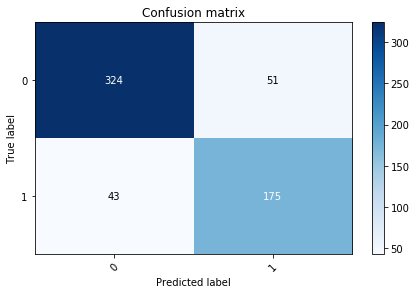

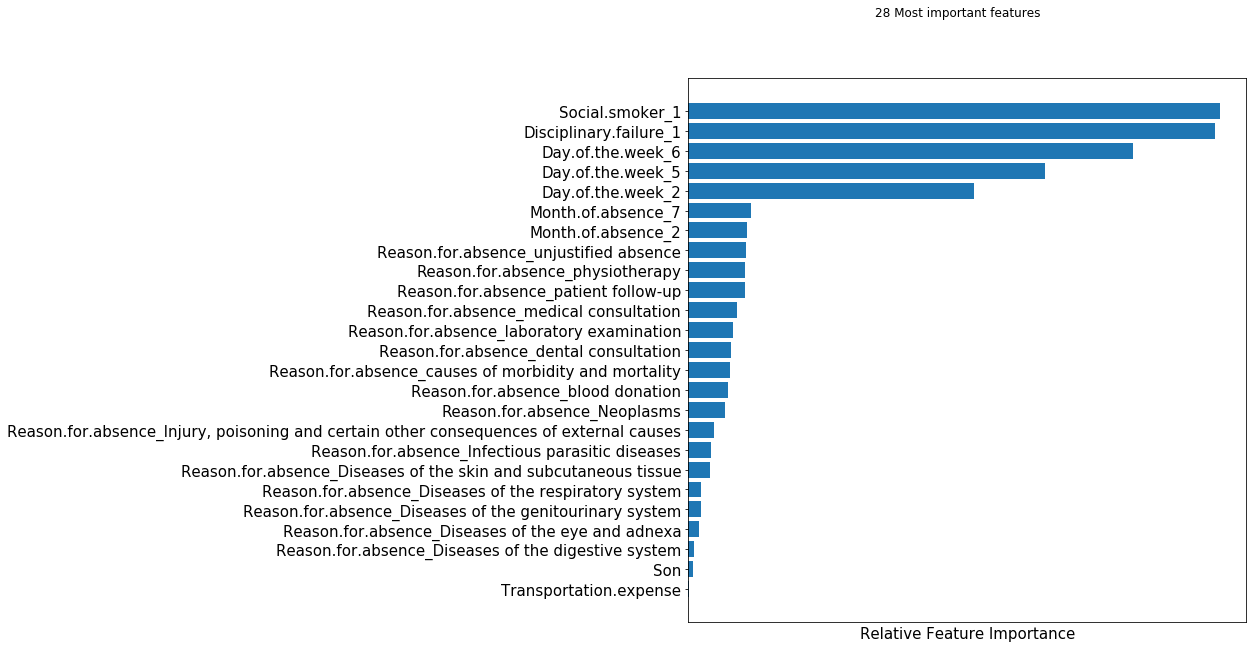

In [75]:
chi2_features_to_remove = dict(filter(lambda x: x[1] <= chi2_th, chi2_features.items())).keys()
print("Features to remove = {}".format(chi2_features_to_remove))
chi2_model, score = train_model(dummified_dataset.iloc[0:593].drop(list(chi2_features_to_remove)+['Absenteeism'], axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))




## Information Gain selection

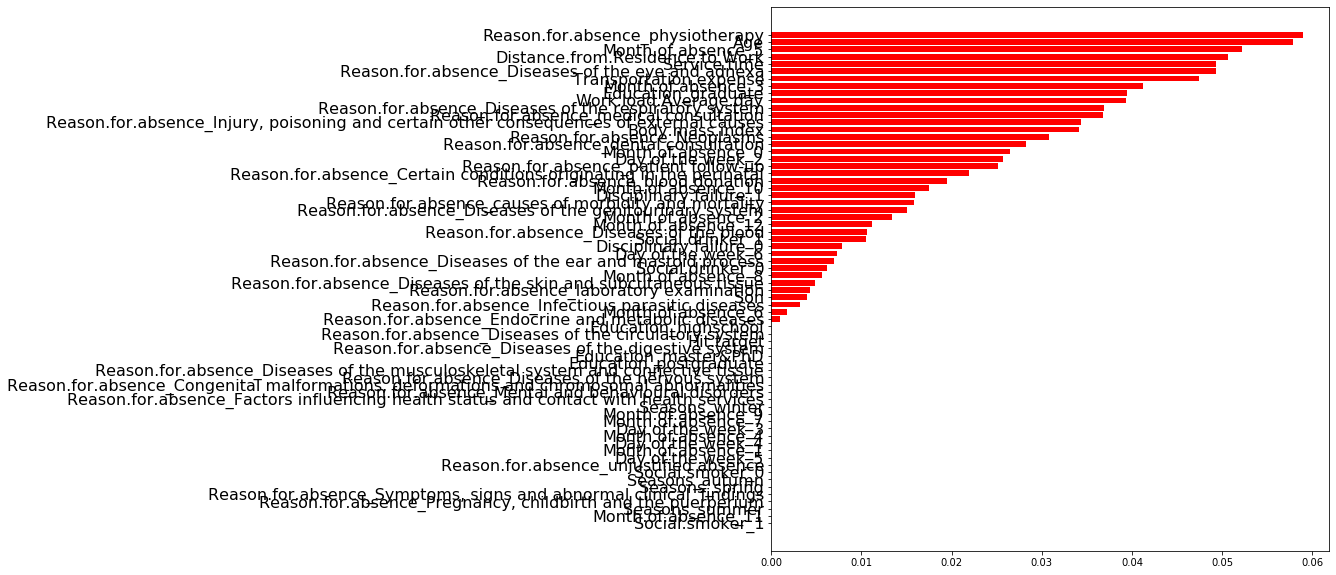

In [76]:
from sklearn.feature_selection import mutual_info_classif

X, Y = dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism']
ig_selector = SelectKBest(score_func=mutual_info_classif).fit(X,Y)

# Get the indices sorted by most important to least important
indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(10,10))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(ig_features, ig_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

This test allows us to see the accuracy of the model, given the specific number of features:

In [77]:
for i in range(1,len(ig_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[ig_features[:i]], y_train).predict(X_test[ig_features[:i]]))))
    print()

Features used to train the model = 1
Accuracy = 0.6173

Features used to train the model = 2
Accuracy = 0.6173

Features used to train the model = 3
Accuracy = 0.6173

Features used to train the model = 4
Accuracy = 0.6173

Features used to train the model = 5
Accuracy = 0.6173

Features used to train the model = 6
Accuracy = 0.6429

Features used to train the model = 7
Accuracy = 0.6633

Features used to train the model = 8
Accuracy = 0.6633

Features used to train the model = 9
Accuracy = 0.6684

Features used to train the model = 10
Accuracy = 0.6837

Features used to train the model = 11
Accuracy = 0.6837

Features used to train the model = 12
Accuracy = 0.6888

Features used to train the model = 13
Accuracy = 0.7194

Features used to train the model = 14
Accuracy = 0.7296

Features used to train the model = 15
Accuracy = 0.7398

Features used to train the model = 16
Accuracy = 0.8061

Features used to train the model = 17
Accuracy = 0.8061

Features used to train the model = 18
Ac

Having more features may seem like a perfect way for improving the accuracy of our trained model (reducing the loss) — because the model that will be trained will be more flexible and will take into account more parameters. On the other hand, we need to be extremely careful about overfitting the data. As we know, every dataset has noisy samples. for that reason, we traded off between accuracy and number of features and selected 29.

We decide to go forward with the IG method, due to the fact that Chi Squared does not take into account the correlation between features.

These are the 29 features the method is choosing:

In [78]:
ig_features[:29]

['Reason.for.absence_physiotherapy',
 'Age',
 'Month.of.absence_5',
 'Distance.from.Residence.to.Work',
 'Service.time',
 'Reason.for.absence_Diseases of the eye and adnexa',
 'Transportation.expense',
 'Month.of.absence_3',
 'Education_graduate',
 'Work.load.Average.day',
 'Reason.for.absence_Diseases of the respiratory system',
 'Reason.for.absence_medical consultation',
 'Reason.for.absence_Injury, poisoning and certain other consequences of external causes',
 'Body.mass.index',
 'Reason.for.absence_Neoplasms',
 'Reason.for.absence_dental consultation',
 'Month.of.absence_0',
 'Day.of.the.week_2',
 'Reason.for.absence_patient follow-up',
 'Reason.for.absence_Certain conditions originating in the perinatal',
 'Reason.for.absence_blood donation',
 'Month.of.absence_10',
 'Disciplinary.failure_1',
 'Reason.for.absence_causes of morbidity and mortality',
 'Reason.for.absence_Diseases of the genitourinary system',
 'Month.of.absence_2',
 'Month.of.absence_12',
 'Reason.for.absence_Diseas

After choosing the method, we start plotting different models to find the optimal one for our prediction with the 29 features given by the IG method

### Linear Model

We load the needed libraries and run the Logistin Regression model with our training set:

In [79]:
from sklearn.linear_model import LogisticRegression

In [82]:
ig_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
ig_initial_lm_mod.fit(X_train[ig_features[:29]], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

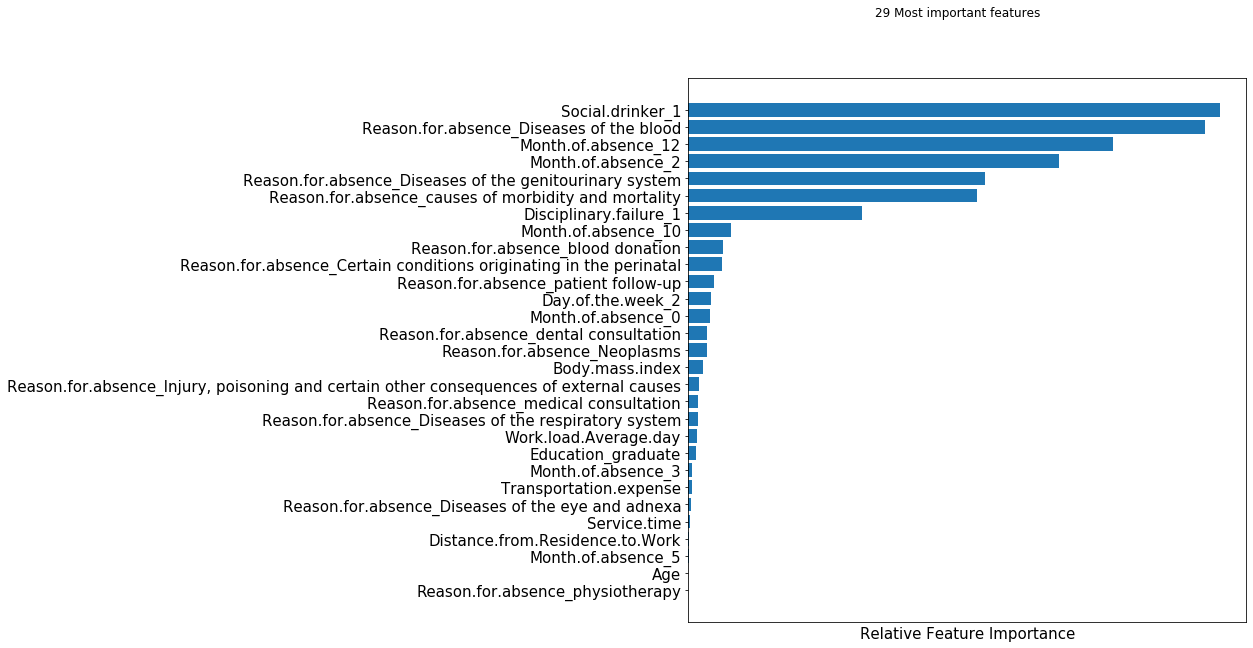

In [83]:
get_feature_importance(ig_initial_lm_mod, ig_features[:29], n_features=29)

In [84]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

Accuracy = 0.8520


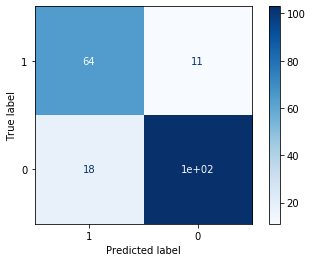

In [86]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:29]]))))
plot_confusion_matrix(ig_initial_lm_mod, X_test[ig_features[:29]], y_test, y_test.unique(), cmap=plt.cm.Blues)

This gives us an accuracy of 0.85. We are seeking to find a more accurate one, so we will now experiment with embedded methods:

### Embedded method

The following two methods work with the aim of regularization, reducing the standard error: 

#### 1. Ridge

Ridge Regression is a technique that works by adding a degree of bias to the regression estimates, and then reduces the standard errors

In [87]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
ridge_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

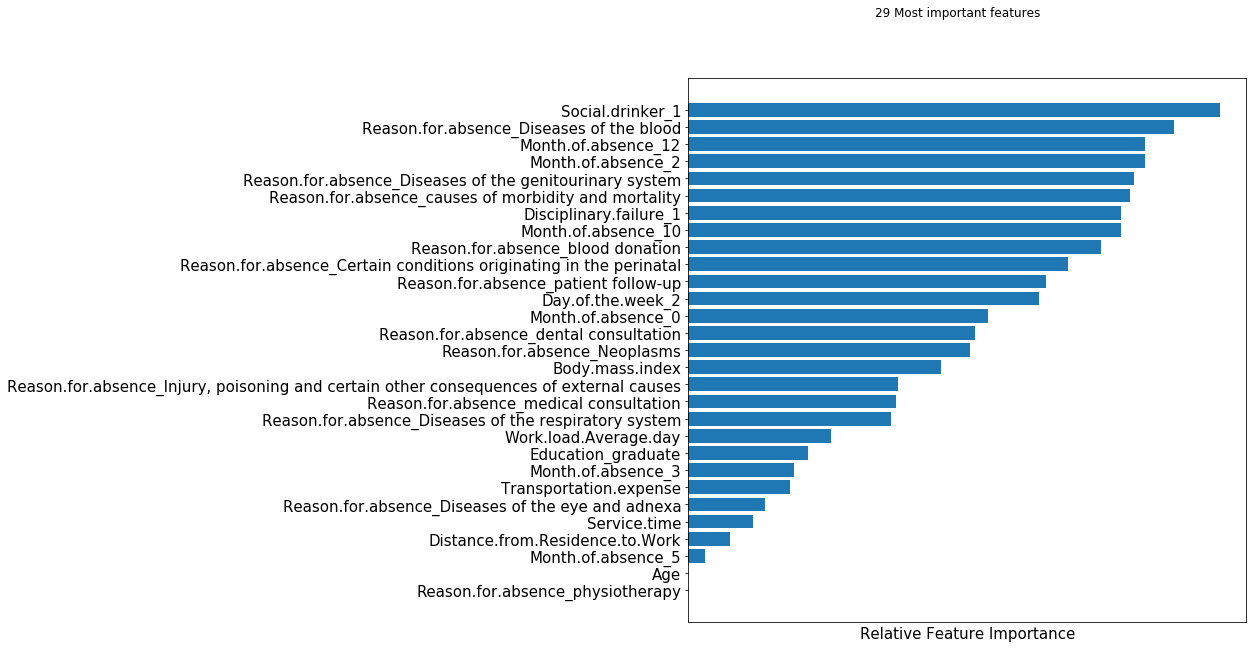

In [88]:
get_feature_importance(ridge_mod, ig_features[:29], n_features = 29)

Accuracy = 0.8367


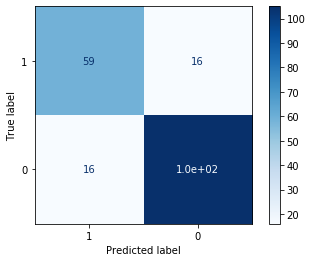

In [89]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod.predict(X_test))))
plot_confusion_matrix(ridge_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

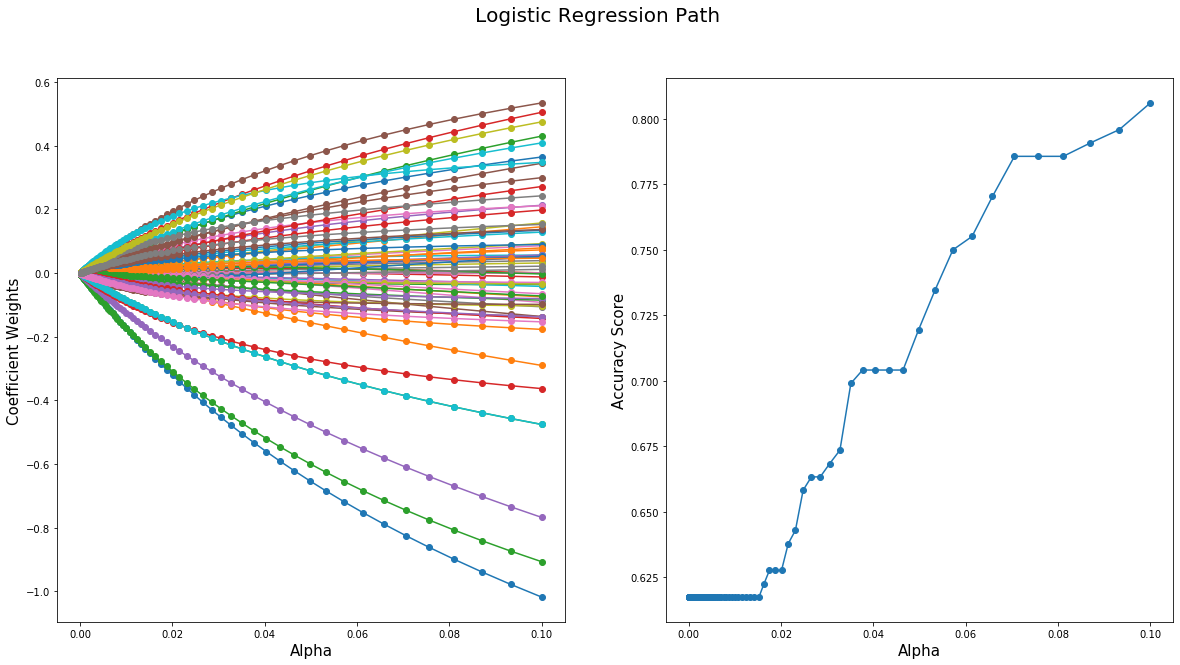

In [90]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    ridge_mod.set_params(C=a)
    ridge_mod.fit(X_train, y_train)
    coefs_.append(ridge_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,ridge_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

We will now run a Cross Validation with the Ridge Method from our training set:

In [91]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.8061


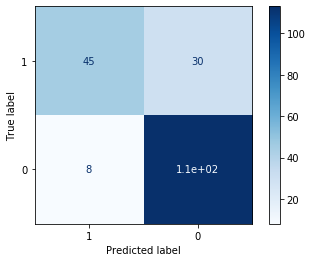

In [92]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod_cv.predict(X_test))))
plot_confusion_matrix(ridge_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

### 2. Lasso

Lasso regression is a type of regression analysis in which both variable selection and regulization occurs simultaneously. This method uses a penalty which affects they value of coefficients of regression, as the regularization:

In [93]:
lasso_mod = linear_model.LogisticRegression(penalty='l2', solver='liblinear')
lasso_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

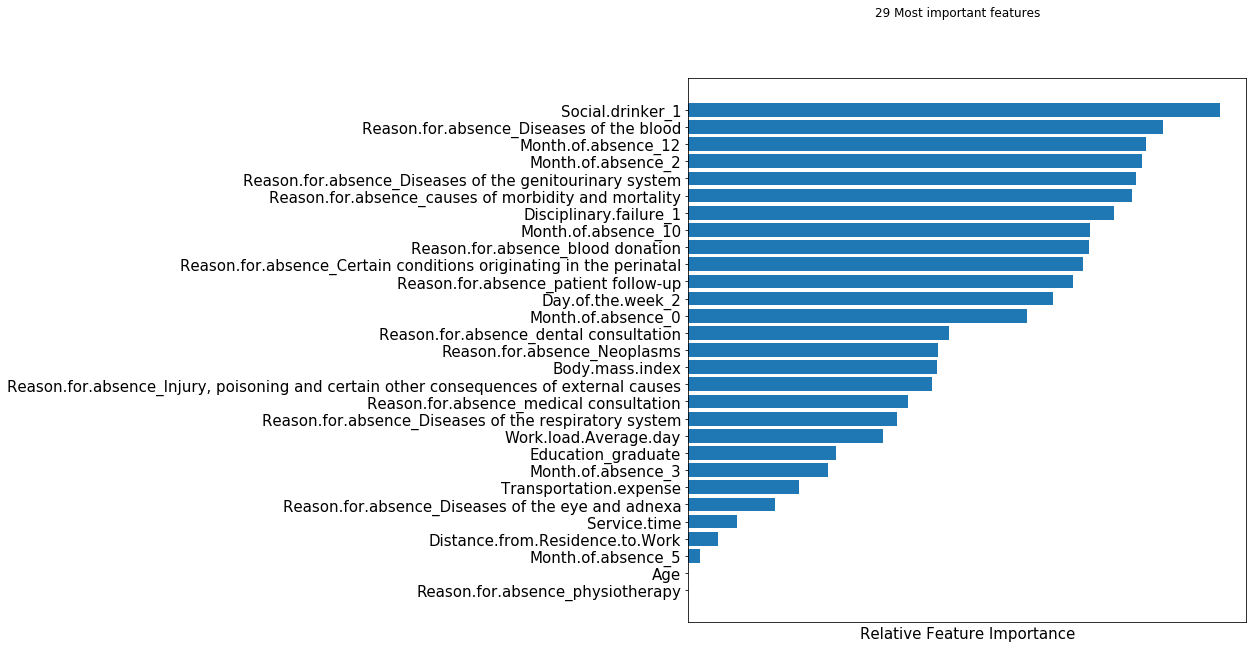

In [94]:
get_feature_importance(lasso_mod, ig_features[:29], n_features=29)

Accuracy = 0.8367


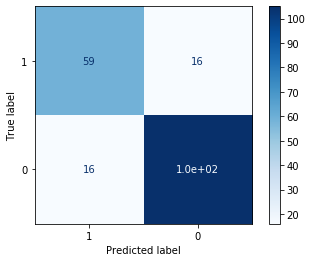

In [95]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod.predict(X_test))))
plot_confusion_matrix(lasso_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

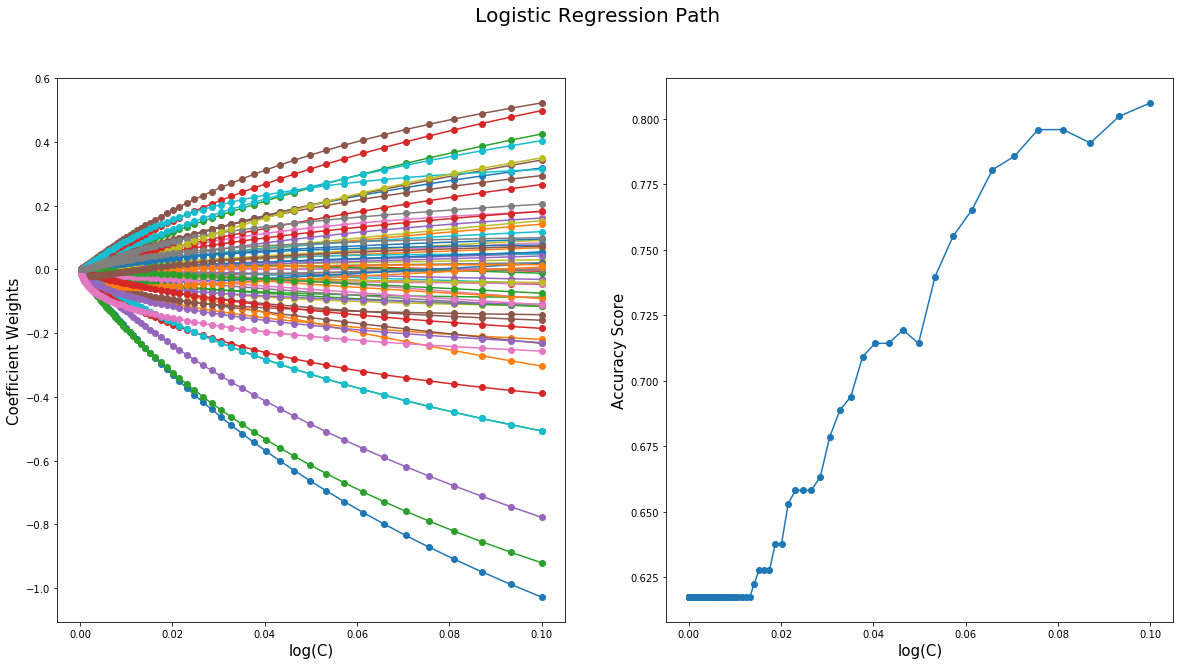

In [96]:
lasso_mod = linear_model.LogisticRegression(penalty='l2',solver='liblinear')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    lasso_mod.set_params(C=a)
    lasso_mod.fit(X_train, y_train)
    coefs_.append(lasso_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,lasso_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('log(C)', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('log(C)', fontsize = 15)
ax2.axis('tight')

plt.show()

Cross Validation for the Lasso Method

In [97]:
from sklearn.feature_selection import SelectFromModel

lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',solver='liblinear',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.8061


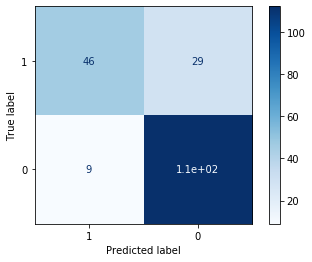

In [98]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod_cv.predict(X_test))))
plot_confusion_matrix(lasso_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

Now, we will compare the Cross validated scores and select the highest one since we are looking for the most accurate result:

1. Ridge CV: 0.8061
2. Lasso CV:0.8061

Same scores! But we decided to pick the Lasso method. 

Now that we selected the lasso score, we run a model using this method and check for the number of features that this model selected:

In [100]:
model = SelectFromModel(lasso_mod_cv, prefit=True)
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(X_train.shape[1], X_new.shape[1]))

Original Number of Features = 68 --> Number of features selected by Lasso = 22


The lasso model selected 22 features out of the 69 originally present in the train dataset

Let´s train the model by using only Lasso features

Accuracy = 0.8367


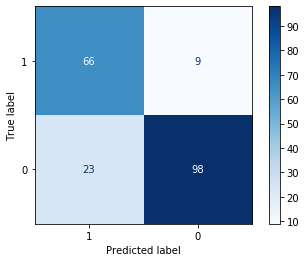

In [101]:
reduced_lasso_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')
reduced_lasso_mod.fit(X_new, y_train)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))))
plot_confusion_matrix(reduced_lasso_mod, X_test_new, y_test, y_test.unique(), cmap=plt.cm.Blues)

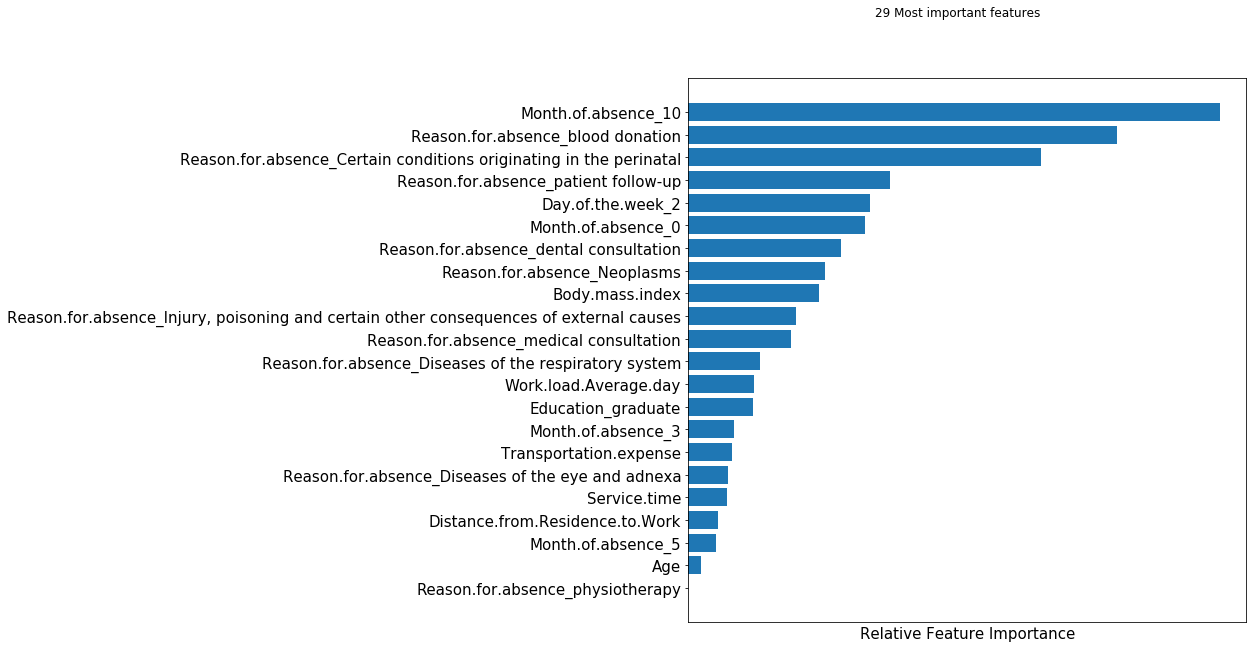

In [102]:
get_feature_importance(reduced_lasso_mod, ig_features[:29], n_features = 29)

# Final Submission

In this part, we finally have our train set ready for modelling. We decided to run the Random Forest algorithm first beacuse it works well with caterogical variables, it produces a highly accurate classifier and also, it is a model that is robust to overfitting (overfitting is something we always want to avoid!). Furtheremore, it is very fast ans effective in working with any type and size of dataset:

In [103]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [104]:
from sklearn.ensemble import RandomForestRegressor

In [105]:
rf = RandomForestClassifier(n_estimators=10, max_depth=10)
rf_model = rf.fit(X,Y)
rf_model.predict(dummified_dataset.iloc[593:].drop(columns='Absenteeism'))
rf_model.score(X,Y)

0.9460370994940978

In [106]:
rfm = RandomForestClassifier(n_estimators=1000)

In [107]:
final_model = rfm.fit(X, Y)
# Test prediction
final_pred = final_model.predict(dummified_dataset.iloc[593:].drop(columns='Absenteeism'))

In [108]:
predictions = pd.DataFrame({'ID':test['ID'], 'Absenteeism.time.in.hours':final_pred})
predictions.to_csv("predictions.csv", index=False)

We got almost 95% accuracy using random forest and we believe the predictions given by this model are able to fulfill the expected precision of a good machine learning algorithm.

Kindly find attached the prediction.csv file in the submission folder.